# Setup

In [48]:
import pandas as pd
import datetime as dt
import urllib.request, json 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
with urllib.request.urlopen('https://impfdashboard.de/static/data/metadata.json') as url:
    data = json.loads(url.read().decode())
    print(data)

{'vaccinationsLastUpdated': '2021-06-10 11:05:00', 'deliveryLastUpdated': '2021-06-07 10:40:00'}


In [3]:
data_url = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
data_lieferung_url = 'https://impfdashboard.de/static/data/germany_deliveries_timeseries_v2.tsv'

In [4]:
df = pd.read_csv(data_url, sep='\t')
df_lieferungen = pd.read_csv(data_lieferung_url, sep='\t')

In [5]:
df.columns

Index(['date', 'dosen_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_biontech_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_astrazeneca_kumulativ', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'impf_quote_erst', 'impf_quote_voll',
       'indikation_alter_dosen', 'indikation_beruf_dosen',
       'indikation_medizinisch_dosen', 'indikation_pflegeheim_dosen',
       'indikation_alter_erst', 'indikation_beruf_erst',
       'indikation_medizinisch_erst', 'indikation_pflegeheim_erst',
       'indikation_alter_voll', 'indikation_beruf_voll',
       'indikation_medizinisch_voll', 'indikation_pflegeheim_voll',
       'dosen_dim_kumulativ', 'dosen_kbv_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ',
       'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
       'dosen_astrazeneca_erst_kumulativ', 'dosen_astr

In [6]:
df.date.iloc[-1]

'2021-06-09'

# Impfstofflieferungen

In [7]:
df_lieferungen_bund = df_lieferungen.groupby(["date", "impfstoff"], as_index=False).sum()

In [8]:
df_lieferungen_bund["date"] = pd.to_datetime(df_lieferungen_bund.date)

In [9]:
df_lieferungen_bund = df_lieferungen_bund.groupby(["impfstoff", pd.Grouper(key='date', freq='W-MON')]).sum().reset_index().sort_values('date')

In [10]:
df_lieferungen_bund.impfstoff.unique()

array(['comirnaty', 'moderna', 'astra', 'johnson'], dtype=object)

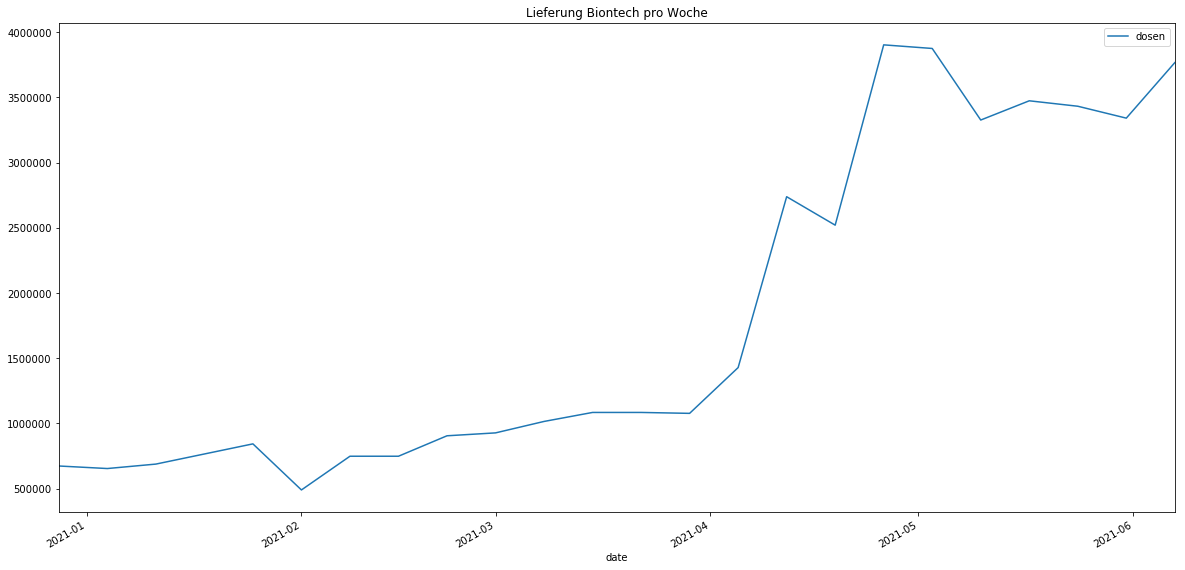

In [28]:
df_lieferungen_bund[df_lieferungen_bund.impfstoff == 'comirnaty'].plot('date', title="Lieferung Biontech pro Woche")
plt.show()

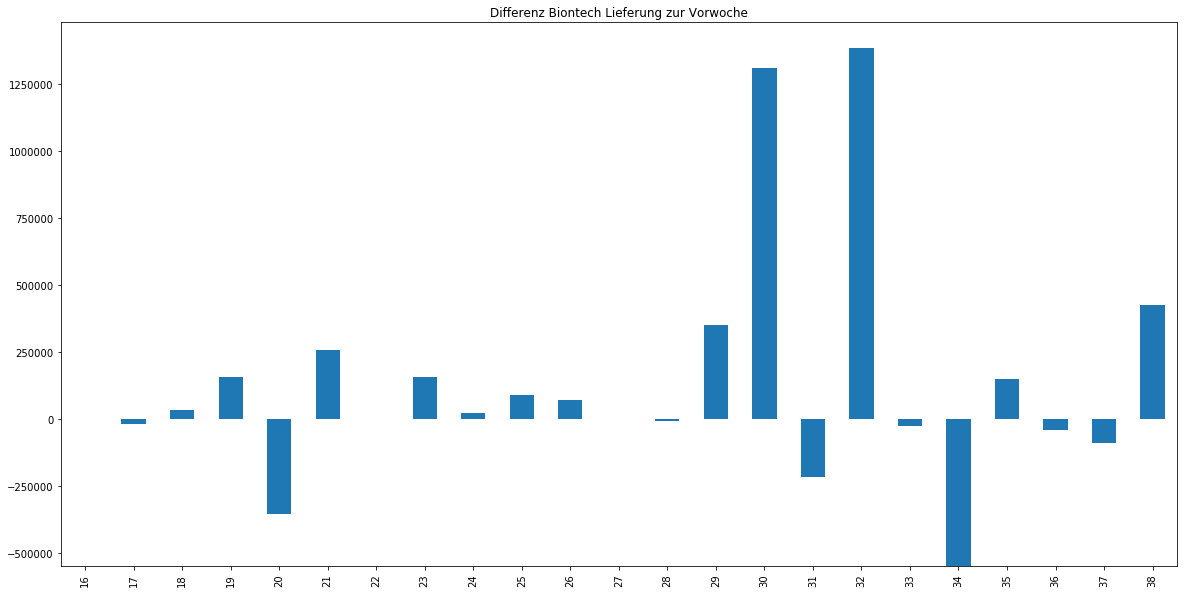

In [29]:
df_lieferungen_bund[df_lieferungen_bund.impfstoff == 'comirnaty'].dosen.diff().plot(kind='bar', title="Differenz Biontech Lieferung zur Vorwoche")
plt.show()

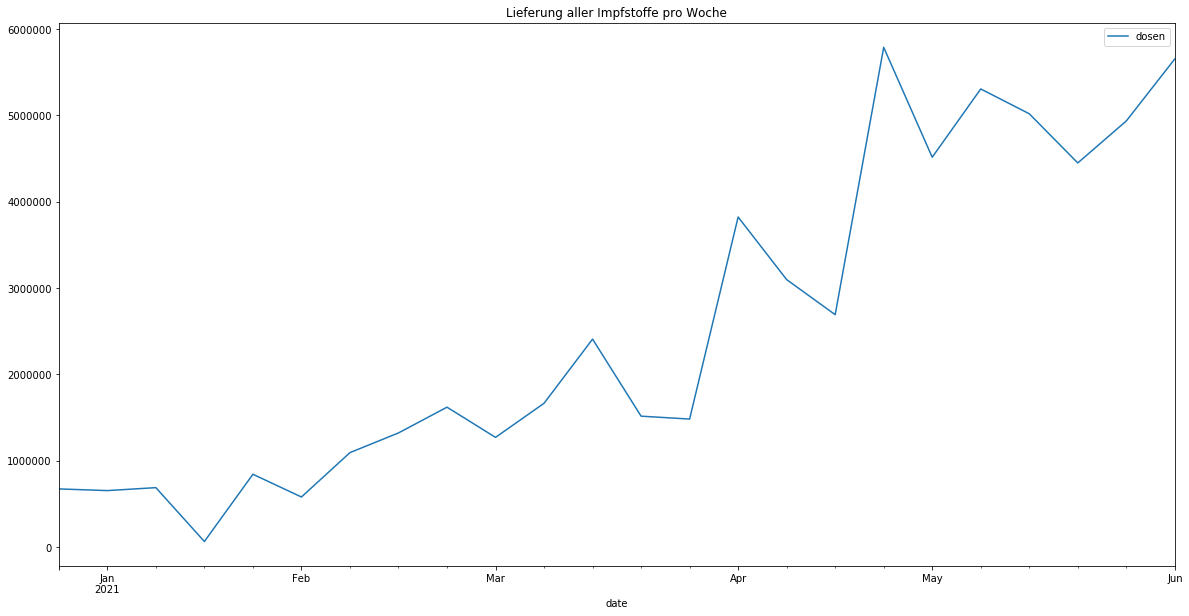

In [30]:
df_lieferungen_bund.groupby("date").sum().plot(title="Lieferung aller Impfstoffe pro Woche")
plt.show()

# Verimpfte Dosen

In [14]:
df["date"] = pd.to_datetime(df.date)

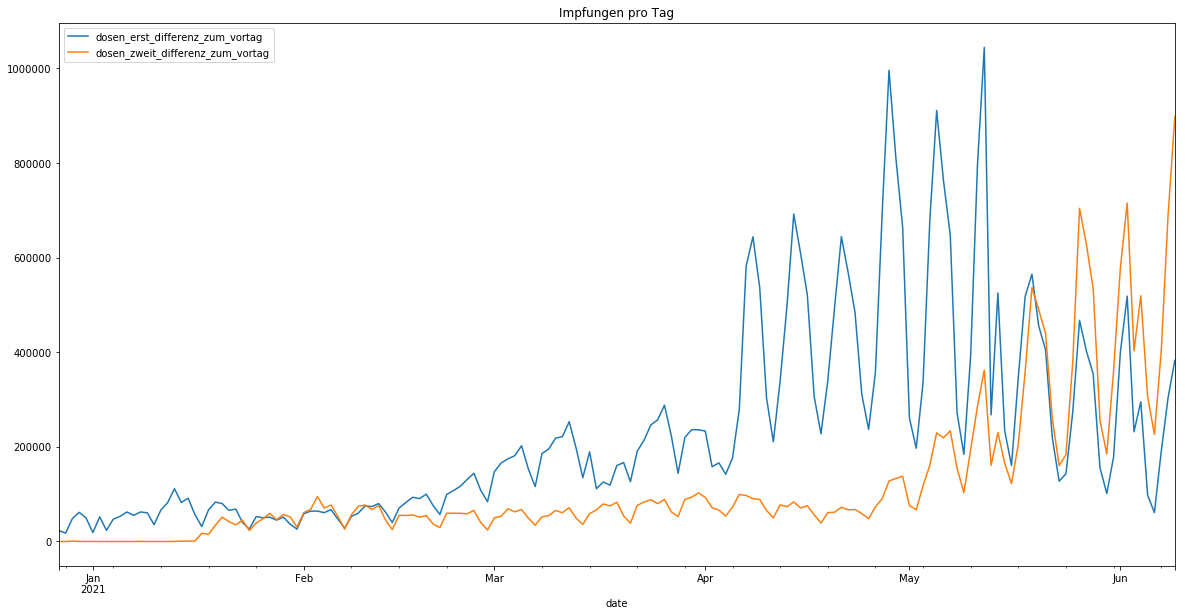

In [31]:
df.plot('date', ['dosen_erst_differenz_zum_vortag','dosen_zweit_differenz_zum_vortag'], title="Impfungen pro Tag")
plt.show()

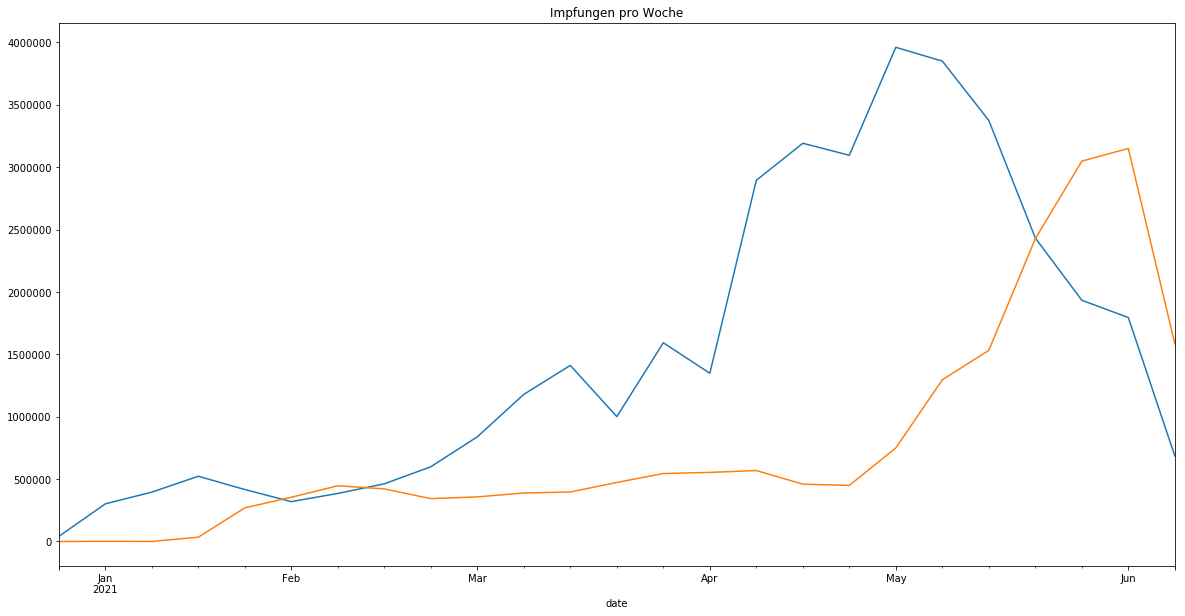

In [34]:
df.groupby(pd.Grouper(key='date', freq='W-MON')).sum()['dosen_erst_differenz_zum_vortag'].plot(title="Impfungen pro Woche")
df.groupby(pd.Grouper(key='date', freq='W-MON')).sum()['dosen_zweit_differenz_zum_vortag'].plot()
plt.show()

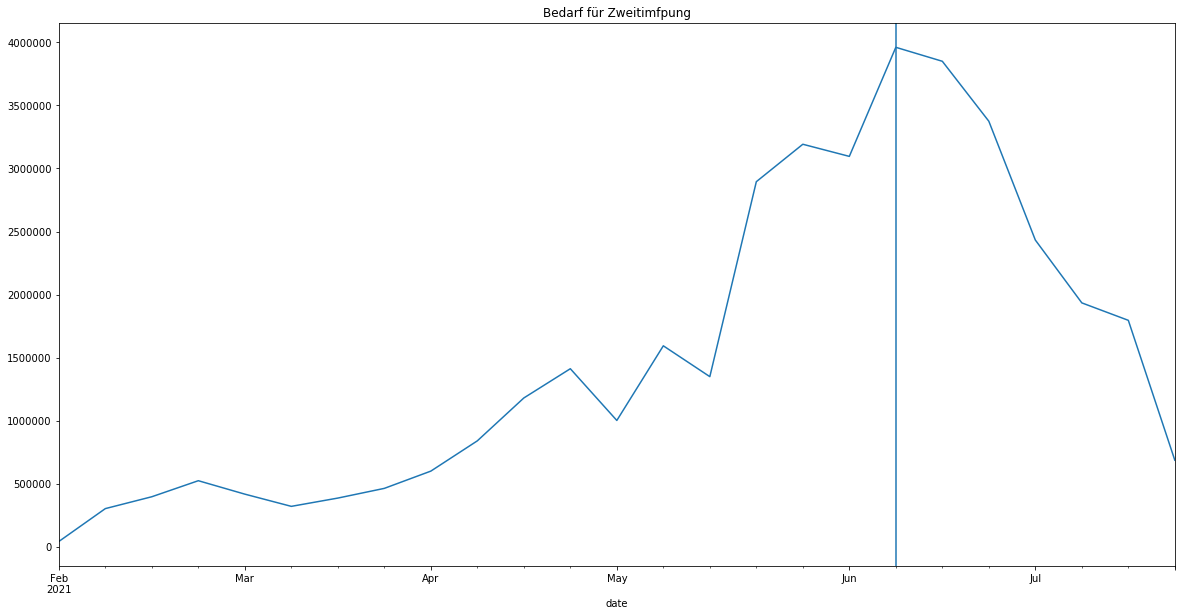

In [47]:
df_prognose = df.groupby(pd.Grouper(key='date', freq='W-MON')).sum()['dosen_erst_differenz_zum_vortag']
df_prognose.index = df_prognose.index.shift(6, freq='w')
df_prognose.plot(title="Bedarf für Zweitimfpung")
plt.axvline(dt.datetime.today())
plt.show()

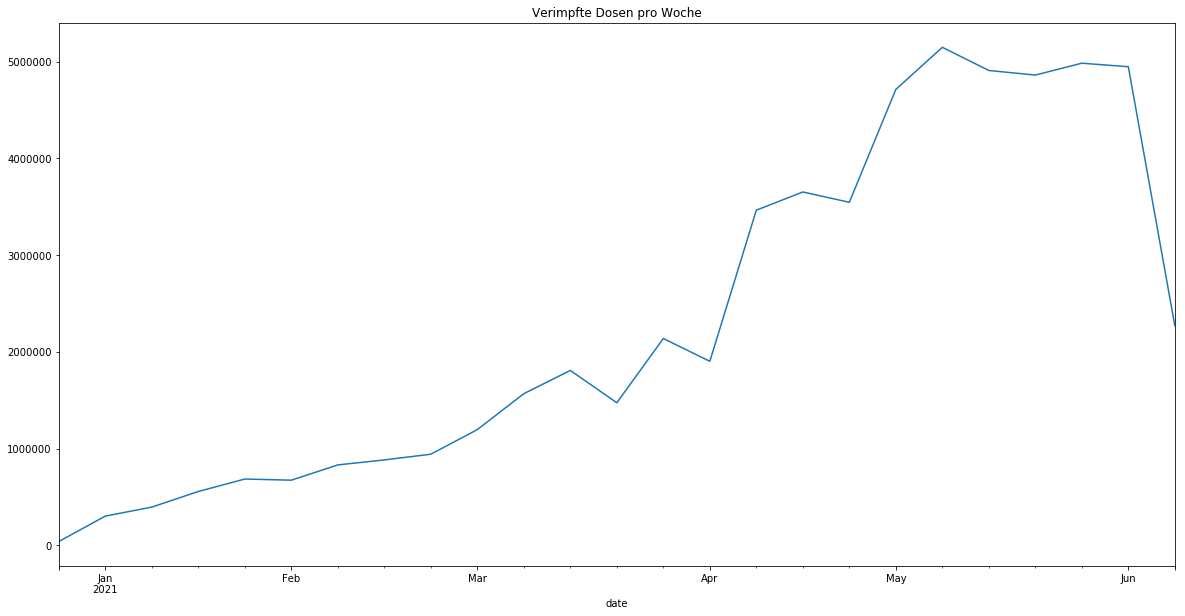

In [35]:
df.groupby(pd.Grouper(key='date', freq='W-MON')).sum()['dosen_differenz_zum_vortag'].plot(title="Verimpfte Dosen pro Woche")
plt.show()

In [19]:
df['anteil_erstimfpung'] = (100.0 * df.dosen_erst_differenz_zum_vortag / df.dosen_differenz_zum_vortag)

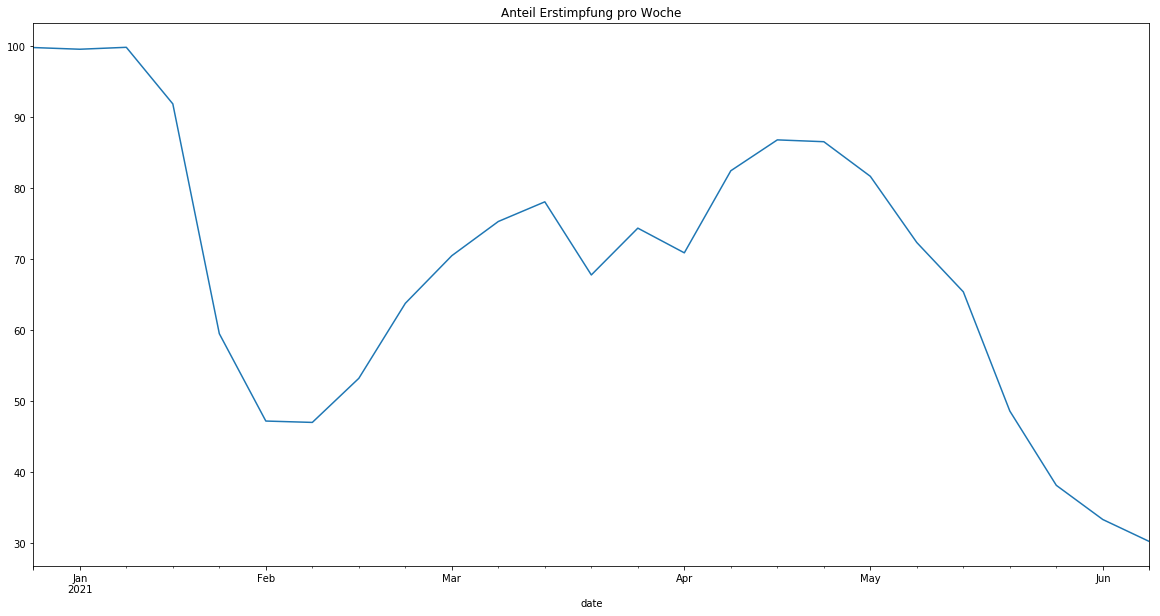

In [36]:
df.groupby(pd.Grouper(key='date', freq='W-MON')).mean()['anteil_erstimfpung'].plot(title="Anteil Erstimpfung pro Woche")
plt.show()

In [21]:
df['delta_erstimpfung_prozent'] = df.impf_quote_erst.diff()*100.0

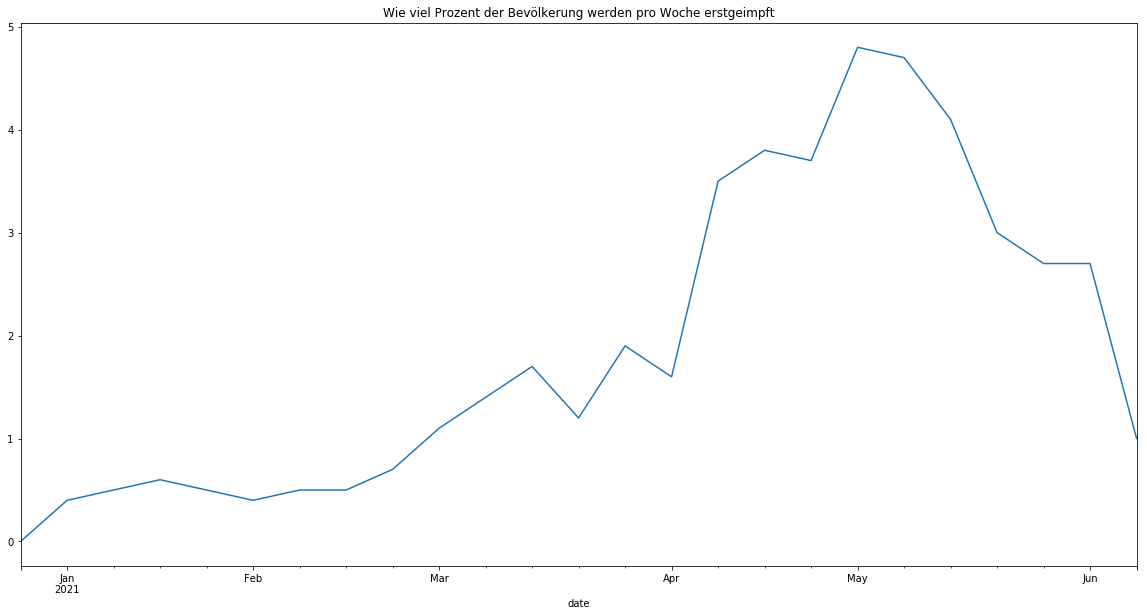

In [37]:
df.groupby(pd.Grouper(key='date', freq='W-MON')).sum()['delta_erstimpfung_prozent'].plot(title="Wie viel Prozent der Bevölkerung werden pro Woche erstgeimpft")
plt.show()

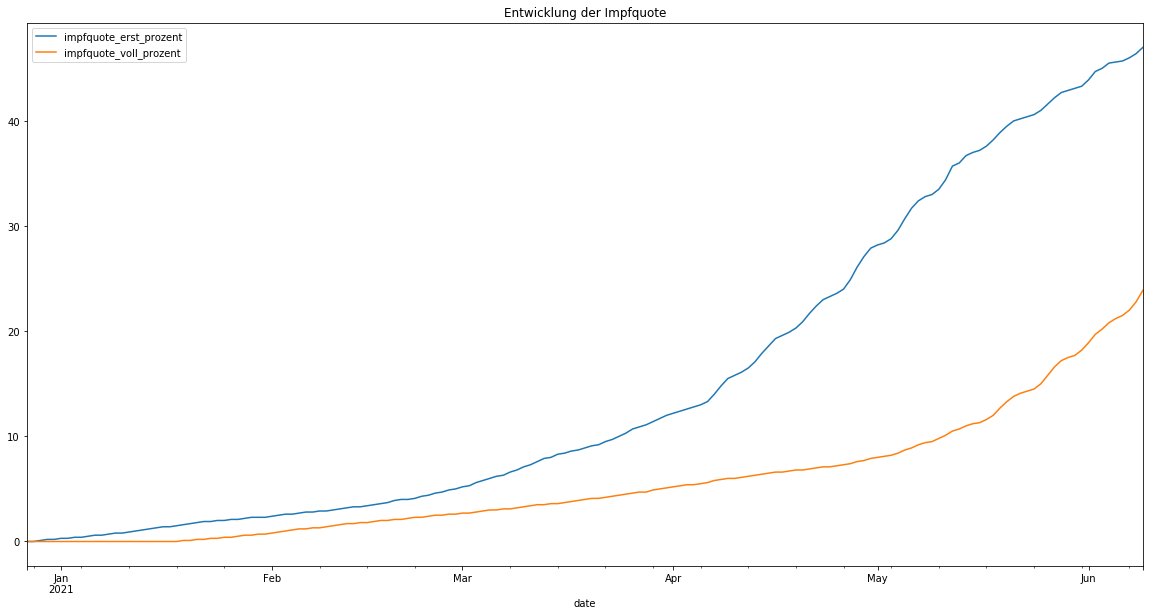

In [38]:
df["impfquote_erst_prozent"] = df.impf_quote_erst * 100.0
df["impfquote_voll_prozent"] = df.impf_quote_voll* 100.0
df["impfquote_gap"] = df.impfquote_erst_prozent - df.impfquote_voll_prozent
df.plot("date", ["impfquote_erst_prozent", "impfquote_voll_prozent"], title="Entwicklung der Impfquote")
plt.show()

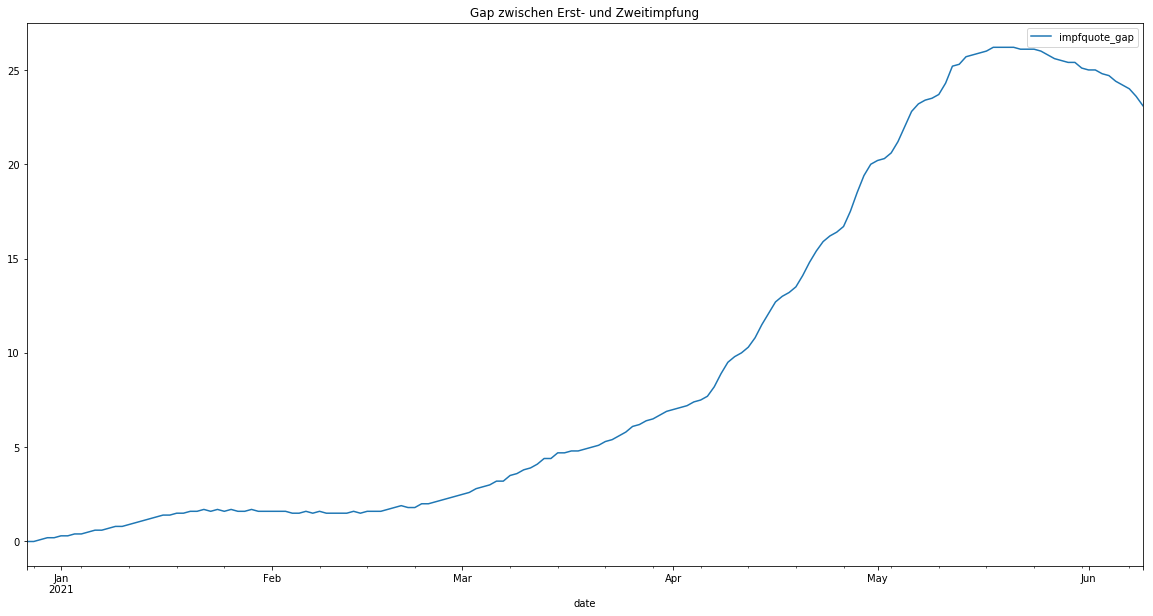

In [39]:
df.plot("date", "impfquote_gap", title="Gap zwischen Erst- und Zweitimpfung")
plt.show()